# 利用SVM进行高光谱图像分类大综合

# 1.加载遥感图像的.mat数据进行呈图显示

In [16]:
# 加载数据
import matplotlib.pyplot as plt  
import numpy as np
from scipy.io import loadmat
import spectral
from functools import reduce 

# 获取mat格式的数据，loadmat输出的是dict，需要进行定位
input_image = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas.mat')['salinas']
output_image = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas_gt.mat')['salinas_gt']

# input_image.shape      # (512, 217, 224)
# output_image.shape     # (512, 217)
# np.unique(output_image)  # array([ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],dtype=uint8)


In [17]:
# 统计每类样本所含个数
dict_k = {}
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] in [m for m in range(1,17)]:
        #if output_image[i][j] in [1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13]:
            if output_image[i][j] not in dict_k:
                dict_k[output_image[i][j]]=0
            dict_k[output_image[i][j]] +=1
            
print(dict_k)
print(reduce(lambda x,y:x+y,dict_k.values()))

# {6: 3959, 7: 3579, 4: 1394, 5: 2678, 15: 7268, 8: 11271, 3: 1976, 2: 3726, 1: 2009, 11: 1068, 12: 1927, 13: 916, 14: 1070, 10: 3278, 9: 6203, 16: 1807}
# 54129


{6: 3959, 7: 3579, 4: 1394, 5: 2678, 15: 7268, 8: 11271, 3: 1976, 2: 3726, 1: 2009, 11: 1068, 12: 1927, 13: 916, 14: 1070, 10: 3278, 9: 6203, 16: 1807}
54129


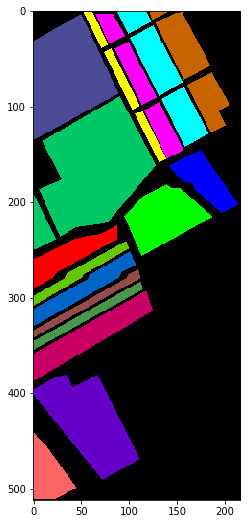

In [18]:
# 展示地物
ground_truth = spectral.imshow(classes = output_image.astype(int),figsize =(9,9))

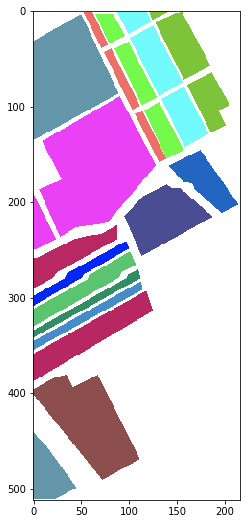

In [19]:
# 不同颜色绘制
my_color =np.array([[255,255,255],
     [184,40,99],
     [74,77,145],
     [35,102,193],
     [238,110,105],
     [117,249,76],
     [114,251,253],
     [126,196,59],
     [234,65,247],
     [141,79,77],
     [183,40,99],
     [0,39,245],
     [90,196,111],
     [50,140,100],
     [70,140,200],
     [100,150,170]])

ground_truth = spectral.imshow(classes = output_image.astype(int),figsize =(9,9),colors=my_color)


# 重构用到的类，转化为CSV文件

In [20]:
# 除掉 0 这个非分类的类，把所有需要分类的元素提取出来
need_label = np.zeros([output_image.shape[0],output_image.shape[1]])   #(512,217)的全零矩阵
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0:
        #if output_image[i][j] in [1,2,3,4,5,6,7,8,9]:
            need_label[i][j] = output_image[i][j]


new_datawithlabel_list = []
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if need_label[i][j] != 0:
            c2l = list(input_image[i][j])
            c2l.append(need_label[i][j])
            new_datawithlabel_list.append(c2l)

new_datawithlabel_array = np.array(new_datawithlabel_list)  
# print(new_datawithlabel_array.shape)  # new_datawithlabel_array.shape (54129,225),包含了数据维度和标签维度，数据225维度，也就是224个波段，最后255列是标签维

In [25]:
from sklearn import preprocessing  
data_D = preprocessing.StandardScaler().fit_transform(new_datawithlabel_array[:,:-1])  #(arry[:, :-1])按逆序展示，去掉了最后一列
# print(data_D.shape)  #(54129, 224)
#data_D = preprocessing.MinMaxScaler().fit_transform(new_datawithlabel_array[:,:-1])

data_L = new_datawithlabel_array[:,-1]
# print(data_L.shape)  #(54129, 224)

# 将结果存档后续处理
import pandas as pd
new = np.column_stack((data_D,data_L))
new_ = pd.DataFrame(new)
new_.to_csv('E:/Hyperspectral/hyperspectral_code/salinas.csv',header=False,index=False)
# 生成csv文件后，就可以直接对该文件进行操作
print('Done')

Done


# 训练模型并存储模型（PCA-LDA-GS-SVM）

In [26]:
import joblib
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import RandomizedPCA
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import time

In [35]:
# 导入数据集切割训练与测试数据

data = pd.read_csv('E:/Hyperspectral/hyperspectral_code/salinas.csv',header=None)
data = data.as_matrix()
data_D = data[:,:-1]  #(54129, 224)
data_L = data[:,-1]   #(54129,)
data_train, data_test, label_train, label_test = train_test_split(data_D,data_L,test_size=0.5)


# 模型训练与拟合linear  rbf  poly
t0 = time()
pca = RandomizedPCA(n_components = 70, whiten=True).fit(data_D)
X_train_pca = pca.transform(data_train) 
X_test_pca = pca.transform(data_test)


lda = LinearDiscriminantAnalysis(n_components = 14).fit(X_train_pca,label_train)
X_train_ida = lda.transform(X_train_pca)
X_test_ida = lda.transform(X_test_pca)

print('OK')

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
# param_grid = {'C': [10, 20, 100, 500, 1e3],
#               'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.125], }
# clf = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid)

clf = SVC(kernel = 'rbf',gamma=0.1,C=20)   # paviau:18-10 rbf 0.1  100  linear 0.125  20  poly 0.1 100  indian:80-40rbf 0.01 100  linear 0.1  20  poly 0.1 100 
clf.fit(X_train_ida,label_train)            #salinas:70-14 rbf 0.1  20    linear 0.125  10  poly 0.1 100
# clf.fit(data_train,label_train)
pred = clf.predict(X_test_ida)
print(pred)
print(pred[100])
print(pred.shape)
print(pred.dtype)
accuracy = metrics.accuracy_score(label_test, pred)*100
print(accuracy)    # 95.60687234435618
# print(clf.best_estimator_)
print("done in %0.3fs" % (time() - t0))  # done in 13.843s
# 存储结果学习模型，方便之后的调用
joblib.dump(clf, "salinas_MODEL.m")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


OK
[15.  8.  4. ...  8. 12.  8.]
11.0
(27065,)
float64
95.49233327175318
done in 13.277s


['salinas_MODEL.m']

In [41]:
array = pred

In [38]:
# 将预测的结果匹配到图像中
new_show = np.zeros((output_image.shape[0],output_image.shape[1]))
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0 :
            new_show[i][j] = pred[k]
            k +=1 
            
# print new_show.shape

# 展示地物
ground_truth = spectral.imshow(classes = output_image.astype(int),figsize =(9,9))
ground_predict = spectral.imshow(classes = new_show.astype(int), figsize =(9,9))

IndexError: index 27065 is out of bounds for axis 0 with size 27065

# 模型预测在图中标记类

In [29]:
# mat文件的导入
import matplotlib.pyplot as plt  
import numpy as np
from scipy.io import loadmat
import spectral


input_image = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas.mat')['salinas']
output_image = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas_gt.mat')['salinas_gt']


testdata = np.genfromtxt('E:/Hyperspectral/hyperspectral_code/salinas.csv',delimiter=',')
data_test = testdata[:,:-1]
label_test = testdata[:,-1]

#在利用训练的model.m模型进行预测时，因为模型经过了PCA与LDA,此时测试时也要经过相同的处理步骤
pca = RandomizedPCA(n_components = 70, whiten=True).fit(data_test)  
data_test_pca = pca.transform(data_test)

lda = LinearDiscriminantAnalysis(n_components = 14).fit(data_test_pca,label_test)
data_test_pca_lda = lda.transform(data_test_pca)
# print(data_test_pca_lda.shape)

print('ok')


ok


In [31]:
# salinas_MODEL.m
clf = joblib.load("salinas_MODEL.m")

predict_label = clf.predict(data_test_pca_lda)

accuracy = metrics.accuracy_score(label_test, predict_label)*100

print(accuracy) # 79.45833102403518


# 将预测的结果匹配到图像中
new_show = np.zeros((output_image.shape[0],output_image.shape[1]))
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0 :
            new_show[i][j] = predict_label[k]
            k +=1 
            
# print new_show.shape





79.45833102403518


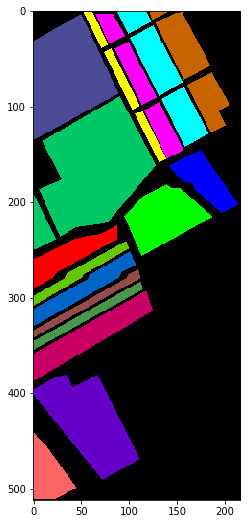

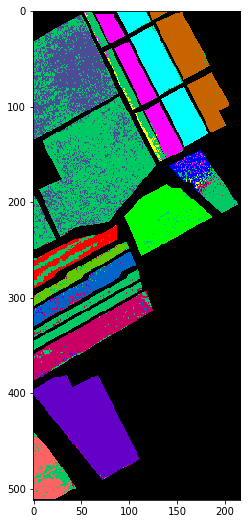

In [32]:
# 将预测的结果匹配到图像中
new_show = np.zeros((output_image.shape[0],output_image.shape[1]))
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0 :
            new_show[i][j] = predict_label[k]
            k +=1 
            
# print new_show.shape

# 展示地物
ground_truth = spectral.imshow(classes = output_image.astype(int),figsize =(9,9))
ground_predict = spectral.imshow(classes = new_show.astype(int), figsize =(9,9))

In [ ]:
# 1.主成分分析（PCA）的降维
# 2.线性判别分析（LDA）的降维
# 3.网格搜索法（GS）寻找最佳参数
# 4.支持向量机SVM的分类

(512, 217, 224)
(111104, 224)
pca.components_ (30, 224)
pca_var_ratio (30,)


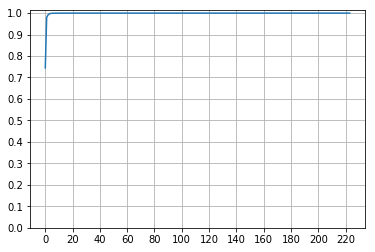

In [3]:
#经过PCA后，减少计算的复杂程度的基础上，尽可能多的保留原始信息
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


X = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas.mat')['salinas']
print (X.shape)
newX = np.reshape(X,(-1,X.shape[2]))
print (newX.shape)
y = loadmat('E:/Hyperspectral/hyperspectral_code/data/Salinas_gt.mat')['salinas_gt']  
#pca=PCA( )
pca=PCA(n_components=0.9999)  # n_components可以写数字或小数，此处表示保留99.99%的原始信息
pca.fit(newX,y)
ratio=pca.explained_variance_ratio_
print("pca.components_",pca.components_.shape)
print("pca_var_ratio",pca.explained_variance_ratio_.shape)
#绘制图形

plt.plot([i for i in range(X.shape[2])],
         [np.sum(ratio[:i+1]) for i in range(X.shape[2])])
plt.xticks(np.arange(X.shape[2],step=20))
plt.yticks(np.arange(0,1.01,0.10))
plt.grid()
plt.show()
# 横坐标：表示保留的维度个数
# 纵坐标：降维后的所有成分的方差和
# (512, 217, 224)
# (111104, 224)
# pca.components_ (30, 224)
# pca_var_ratio (30,)


lda = LinearDiscriminantAnalysis(n_components = 14).fit(X_train_pca,label_train)
X_train_ida = lda.transform(X_train_pca)
X_test_ida = lda.transform(X_test_pca)

In [3]:
#这里还差经LDA后，原始信息含量的波段数的关系（曲线图），进而在减少计算的复杂程度的基础上，尽可能多的保留原始信息

# 网格搜索法（GS）寻找最佳参数

In [30]:
# 此段独立，目的利用网格搜索法找到最佳参数gamma和惩罚因子C，将最佳参数可填入上段SVC函数中
# 但在此应指出的是原始数据集划分成训练集和测试集以后，其中测试集除了用作调整参数，也用来测量模型的好坏；
# 这样做导致最终的评分结果比实际效果好。（因为测试集在调参过程中，送到了模型里,，而我们的目的是将训练模型应用到unseen data上)

# 解决办法：

# 对训练集再进行一次划分，分为训练集和验证集，这样划分的结果就是：原始数据划分为3份，分别为：训练集，验证集和测试集；
# 其中训练集用来模型训练，验证集用来调整参数，而测试集用来衡量模型表现好坏。
# 更多在  https://www.cnblogs.com/wj-1314/p/10422159.html

In [31]:
# # 网格搜索法1
# from sklearn.datasets import load_iris
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# import pandas as pd
# data = pd.read_csv(r'E:\BaiduNetdiskDownload\hyperspectral_datasets\salinas.csv',header=None)
# data = data.as_matrix()
# data_D = data[:,:-1]
# data_L = data[:,-1]
# X_train, X_test, y_train, y_test = train_test_split(data_D,data_L,test_size=0.5)
 
# # grid search start
# best_score = 0
# for gamma in [0.001,0.01,1,10,100]:
#     for c in [0.001,0.01,1,10,100]:
#         # 对于每种参数可能的组合，进行一次训练
#         svm = SVC(gamma=gamma,C=c)
#         svm.fit(X_train,y_train)
#         score = svm.score(X_test,y_test)
#         # 找到表现最好的参数
#         if score > best_score:
#             best_score = score
#             best_parameters = {'gamma':gamma,"C":c}
 
# print('Best socre:{:.2f}'.format(best_score))
# print('Best parameters:{}'.format(best_parameters))

In [32]:
# # 网格搜索法2：引入验证集后，为减少偶然性，引入交叉验证
# from sklearn.datasets import load_iris
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split,cross_val_score
# import pandas as pd

# data = pd.read_csv(r'E:\BaiduNetdiskDownload\hyperspectral_datasets\salinas.csv',header=None)
# data = data.values  #as_matrix
# data_D = data[:,:-1]
# data_L = data[:,-1]
# X_trainval,X_test,y_trainval,y_test = train_test_split(data_D,data_L,test_size=0.2,random_state=0)
# X_train ,X_val,y_train,y_val = train_test_split(X_trainval,y_trainval,random_state=1)


# # grid search start
# best_score = 0
# for gamma in [0.001]:  #,0.01,1,10,100
#     for c in [1]:     #0.001,0.01,,10,100
#         # 对于每种参数可能的组合，进行一次训练
#         svm = SVC(gamma=gamma,C=c)
#         # 5 折交叉验证
#         scores = cross_val_score(svm,X_trainval,y_trainval,cv=5)
#         score = scores.mean()
#         # 找到表现最好的参数  
#         if score > best_score:
#             best_score = score
#             best_parameters = {'gamma':gamma,"C":c}
 
# # 使用最佳参数，构建新的模型
# svm = SVC(**best_parameters)
 
# # 使用训练集和验证集进行训练 more data always resultd in good performance
# svm.fit(X_trainval,y_trainval)
 
# # evalyation 模型评估
# test_score = svm.score(X_test,y_test)
 
# print('Best socre:{:.2f}'.format(best_score))
# print('Best parameters:{}'.format(best_parameters))
# print('Best score on test set:{:.2f}'.format(test_score))